# ベイズ最適化概説
　ディープラーニングになどの機械学習が急速な進化により、それを支える周辺技術も見直され発展してきている。 \
学習計算コストの高いディープラーニングにおけるハイパーパラメータ（層数・層内のユニット数・活性化関数・学習率など）のように、 \
物理的な意味が乏しく、勾配もわからない（微分できない）ブラックボックス関数の最適化もその一つである。

本ノートブックでは、ブラックボックス最適化手法の一つであるベイズ最適化について概説する。

## 勾配法ベースの最適化
　まず、未知の1次元ブラックボックス関数の最小化問題について、従来の勾配法ベースの最適化を適用した場合について下記に示す。 \
初期の実験点n=2から次の実験点を選定するにあたり、2点から近似関数を作り、最小の見込みとなる次の実験点を選定する。 \
選定した実験点の評価結果も追加することを繰り返すことで、最小となるxを探索する。 \
この方法は確実に最小解にたどり着くことができるが、解の不確かさを考慮出来ておらず、局所解に陥りやすい欠点がある。

![optimization_flow](./imgs/opt_flow0.png)



## ベイズ最適化
　同様に１次元ブラックボックス関数の最小化問題についてベイズ最適化を適用する。 \
勾配法ベースとの最大の違いは、ベイズ最適化では作成する近似関数の値そのものを使って最適化するのではなく、 \
近似関数の不確かさ（信頼区間など）も考慮して解の探索を行う点である。
例えば下図のn=6においては、近似関数の不確かさを考慮しなければ次の実験点を選定することなく局所解に陥ってしまうが、 \
x=6付近には実験点がなく近似関数の不確かさが大きく、ベイズ最適化では次の実験点x=6付近を選定している。


![opt_flow_baysian](./imgs/opt_flow1.png)


## 獲得関数
　具体的に、最小化問題において近似関数の不確かさも考慮した上で最小となる見込みのある次の計算点を決定する方法として、 \
以下のような獲得関数の最大化問題を解くことで決定する方法が提案されている(Srinivasら2010)。
 
$$
x_t  = argmax\{-\mu_{t-1}(x)+w_t \cdot \sigma_{t-1}(x)\}
$$

　ここで、$\mu_{t-1},\sigma_{t-1}$は、前回（t-1回）までの計算により作られた回帰モデルの平均と分散であり、$w_t$は重み係数である。また、argmax は { } 内の関数が最大となるxを求解する関数である。$w_t$の値は、前回（t-1回）までの最適解を活用した最小値の求解と、回帰モデル上の不確かな範囲の探索の割合であり、イタレーションに応じて変更することが提案されている。

　実際に上記の１次元ブラックボックス関数の最小化問題では下図のように獲得関数が最大となる点を次の実験点としている。


![argmax f(x)](./imgs/opt_flow2.png)

---

# ベイズ最適化の例題

　2変数関数の最小化問題にベイズ最適化を適用する例題を実施する。 \
　本来ベイズ最適化は、勾配のわからないブラックボックス関数の最適化に利用される手法であるが、 \
本サンプルでは最適化のベンチマーク関数のRosenbrock関数を用いる（ただし、勾配は利用しない）

　次に、ベイズ最適化の適用には、PythonライブラリであるGPyOptを用いる。 \
各セルのサンプルコードの実行は、Shift + Enterである。

## 最適化問題
+ 最小化問題 \
    $x_{opt} = argmin\{f(x)\}$

+ 目的関数 Rosenbrock function \
    $f(x) = (1-x_0)^2 + 100*(x_1-x_0^2)^2$
+ 制約条件 \
    $-2.0 < x_0 < 2.0$, \
    $-0.5 < x_1< 3$
 
尚、解析解は、 $0.0$ @ $x_0 = 1.0$, $x_1 = 1.0$である。
    
## 関数の定義
　まず関数の定義を行う。Pythonでは制御文の有効範囲をインデント（推奨：半角スペース4ケ）で行う。
例えば、関数rosenbrockは下記のようにあらわすことができる。

In [1]:
def rosenbrock(x):
    return (1-x[:,0])**2 + 100*(x[:,1]-x[:,0]**2)**2

この関数は、配列の変数xを引数とし、計算結果を返す。
配列の変数xは具体的には1行2列の配列であり、下記のように数値計算ライブラリnumpyの配列として定義できる。

In [2]:
import numpy as np

x = np.array([[0,0]])
x.shape

(1, 2)

上記の変数xをrosenbrock関数に渡すことで、目的関数の評価が可能である。

In [3]:
rosenbrock(x)

array([1])

## 関数のプロット
　最適化問題がイメージしやすいように、Rosenbrock関数をプロットする。
下記のセルを実行する。ソースコードの説明に関しては、最適化に直接関係ないので割愛する。

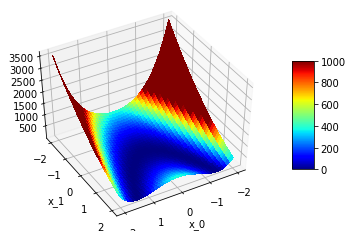

In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x0 = np.linspace(-2,2,40)
xg, yg = np.meshgrid(x0,x0)
xgyg = np.hstack([xg.reshape(-1,1),yg.reshape(-1,1)])
z = rosenbrock(xgyg).reshape(xg.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xg, yg, z, cmap="jet",
                       linewidth=0, antialiased=False, vmin = 0, vmax = 1000)
ax.view_init(45, 60)
ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
fig.colorbar(surf, shrink=0.5, aspect=5)

## 設計変数の定義
　最適化を行うにあたり、設計変数を定義する必要がある。
GPyOptでは、各変数の情報を辞書型のデータで記述したリストで表す。
例えば、連続する値を持つ2変数であれば下記のように定義する。

In [5]:
bounds =[{'name': 'x_0', 'type': 'continuous', 'domain': (-2,2)}, 
         {'name': 'x_1', 'type': 'continuous', 'domain': (-0.5,3)}]

ここで、boundsリストの第一の変数の、変数の範囲は次のようにアクセスできる。

In [6]:
bounds[0]["domain"]

(-2, 2)

## 最適化の実行
　ベイズ最適化の計算化フローを以下に示す。

![opt_flow_baysian](./imgs/calc_flow3.svg)

今回、初期の実験サンプリングは、5回のラテン超方格実験により決定し、+25回の繰り返し計算を行う。

### 最適化問題の定義
　まず、目的関数、設計変数の範囲、初期実験サンプリング方法、初期サンプル数を引数に最適化問題を定義する。
また、合わせて、数値計算の再現性確保のため、ランダムシードを設定する。

In [7]:
import GPyOpt
from numpy.random import seed

seed(1) 
myProblem = GPyOpt.methods.BayesianOptimization(rosenbrock,
                                                domain=bounds,
                                                initial_design_type ="latin",
                                                initial_design_numdata=5,
                                                maximize=False)

### 最適化繰り返し計算の実行
　初期計算+25回の繰り返し計算を行う。

In [8]:
max_iter = 25
myProblem.run_optimization(max_iter) 

### 最適化解
最適化の履歴は下記のコードでプロットできる。

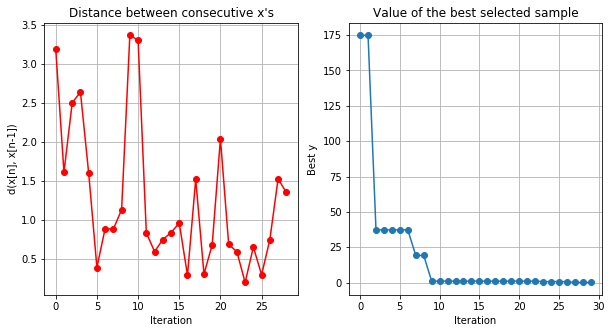

In [9]:
%matplotlib inline 
myProblem.plot_convergence() 

また、具体的な解は下記に格納されている。

In [10]:
print(myProblem.x_opt, myProblem.fx_opt)

[0.84010126 0.73326179] 0.10114671375411918


蛇足であるが、設計変数が2変数であれば、近似関数の平均と分散、獲得関数の描写ができる

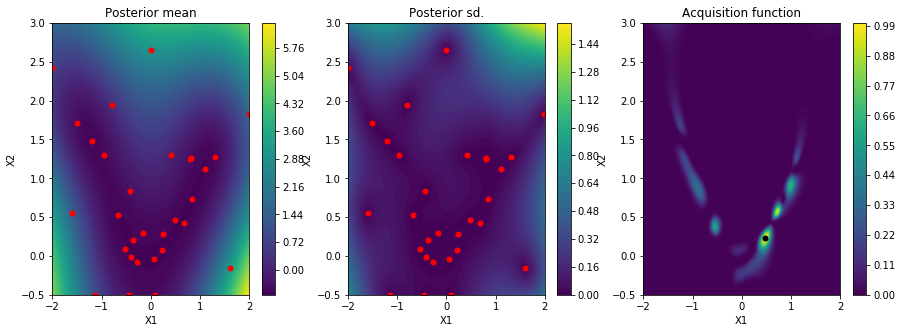

In [11]:
myProblem.plot_acquisition()

以上、ベイズ最適化の概説及び例題に関する学習を終了する